Color Accuracy Report:
Color  Total Samples  Off Samples  Off %  Mean RGB Distance  Max RGB Distance
  Red            768          760  98.96              99.33            170.89
Green            768          768 100.00             176.59            226.06
 Blue            768          768 100.00             169.21            225.03


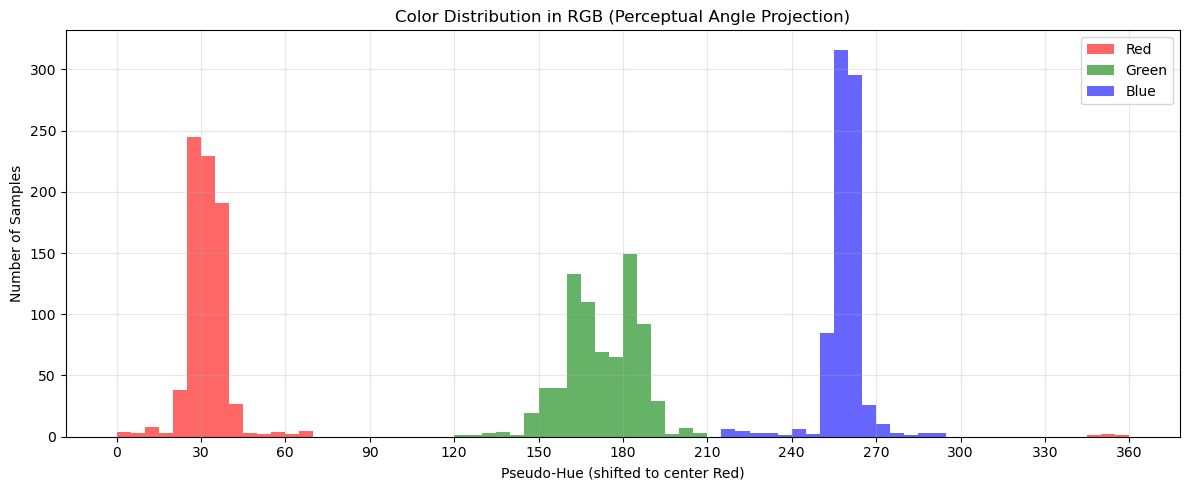

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Reference RGB values
TRUE_COLORS = {
    'Red': (255, 0, 0),
    'Green': (0, 255, 0),
    'Blue': (0, 0, 255)
}

def color_distance(c1, c2):
    """Euclidean distance in RGB space"""
    return np.sqrt(sum((a - b) ** 2 for a, b in zip(c1, c2)))

def pseudo_hue(r, g, b):
    """Approximate perceptual hue using an angle-like projection in RGB space"""
    r_norm, g_norm, b_norm = r / 255, g / 255, b / 255
    angle = np.arctan2(np.sqrt(3) * (g_norm - b_norm), 2 * r_norm - g_norm - b_norm)
    deg = np.degrees(angle) % 360
    return (deg + 30) % 360  # Shift to center red

def analyze_color_accuracy(csv_path, distance_threshold=50):
    df = pd.read_csv(csv_path)
    summary = []
    pseudo_hues = []

    for color_name, true_rgb in TRUE_COLORS.items():
        try:
            r_vals = df[f'{color_name} R']
            g_vals = df[f'{color_name} G']
            b_vals = df[f'{color_name} B']
        except KeyError:
            continue

        total = len(r_vals)
        off_count = 0
        distances = []

        for r, g, b in zip(r_vals, g_vals, b_vals):
            dist = color_distance((r, g, b), true_rgb)
            distances.append(dist)
            hue = pseudo_hue(r, g, b)
            pseudo_hues.append((hue, color_name))
            if dist > distance_threshold:
                off_count += 1

        summary.append({
            'Color': color_name,
            'Total Samples': total,
            'Off Samples': off_count,
            'Off %': (off_count / total) * 100,
            'Mean RGB Distance': np.mean(distances),
            'Max RGB Distance': np.max(distances)
        })

    return pd.DataFrame(summary), pseudo_hues

def plot_rgb_hue_distribution(pseudo_hues):
    bins = np.linspace(0, 360, 73)  # 5-degree bins
    colors = {'Red': 'red', 'Green': 'green', 'Blue': 'blue'}

    plt.figure(figsize=(12, 5))
    for label in TRUE_COLORS:
        hue_vals = [h for h, l in pseudo_hues if l == label]
        plt.hist(hue_vals, bins=bins, alpha=0.6, label=label, color=colors[label])

    plt.xlabel("Pseudo-Hue (shifted to center Red)")
    plt.ylabel("Number of Samples")
    plt.title("Color Distribution in RGB (Perceptual Angle Projection)")
    plt.xticks(np.arange(0, 361, 30))
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Main usage
if __name__ == "__main__":
    csv_path = '/Users/xiaos/Downloads/Suinan_train_data_cleaned.csv'
    report_df, pseudo_hues = analyze_color_accuracy(csv_path)

    print("Color Accuracy Report:")
    print(report_df.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

    plot_rgb_hue_distribution(pseudo_hues)


Cleaned CSV saved to: /Users/xiaos/Downloads/Suinan_train_data_cleaned_cleaned.csv
Filtered Color Accuracy Report (Row-wise removal if any channel is off):
Color  Original Total  Remaining Samples  Removed Samples  Mean RGB Distance  Max RGB Distance
  Red             768                696               72              97.26            150.43
Green             768                696               72             176.52            218.92
 Blue             768                696               72             169.10            225.03
Plot saved to: /Users/xiaos/Downloads/Suinan_train_data_cleaned_cleaned_plot.png


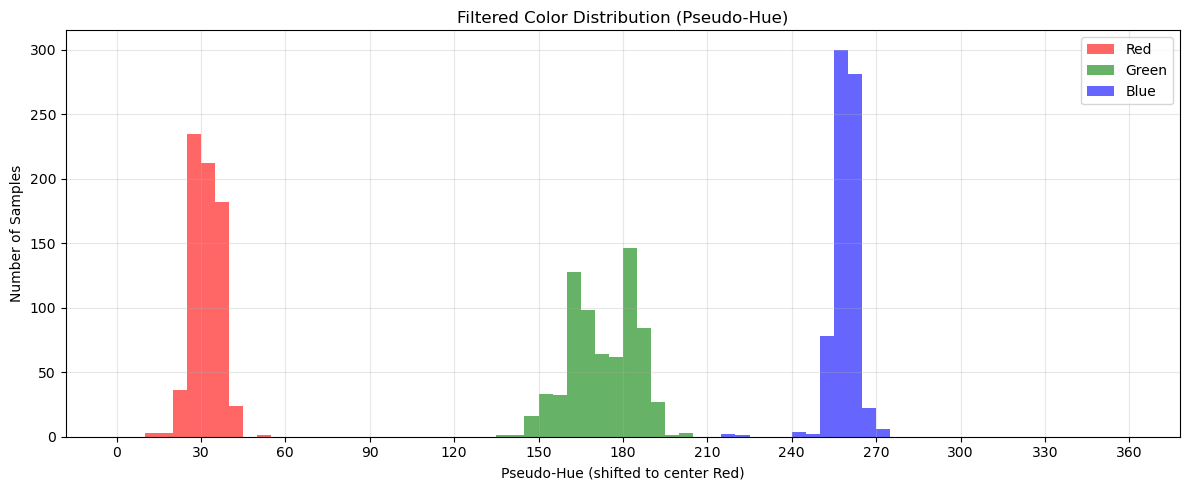

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Reference RGB values (for computing distance and pseudo-hue)
TRUE_COLORS = {
    'Red': (255, 0, 0),
    'Green': (0, 255, 0),
    'Blue': (0, 0, 255)
}

def get_bounds(series):
    """Compute the lower and upper bounds for a series using the IQR rule."""
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

def pseudo_hue(r, g, b):
    """
    Convert an RGB triplet to an approximate perceptual hue.
    The hue is shifted so that red is centered.
    """
    r_norm, g_norm, b_norm = r / 255, g / 255, b / 255
    angle = np.arctan2(np.sqrt(3) * (g_norm - b_norm), 2 * r_norm - g_norm - b_norm)
    deg = np.degrees(angle) % 360
    return (deg + 30) % 360  # shift to center red

def filter_dataframe(df):
    """
    For each color channel column in the DataFrame, compute IQR bounds.
    A row is kept only if every value in its nine columns is within the bounds.
    """
    cols = [f'{color} {ch}' for color in TRUE_COLORS for ch in ['R', 'G', 'B']]
    
    # Dictionary to hold bounds per column
    bounds = {}
    for col in cols:
        lower, upper = get_bounds(df[col])
        bounds[col] = (lower, upper)
    
    # Create a boolean mask: row is valid only if for all columns, value is within bounds.
    valid_mask = np.ones(len(df), dtype=bool)
    for col in cols:
        lower, upper = bounds[col]
        valid_mask &= (df[col] >= lower) & (df[col] <= upper)
    
    # Filter the DataFrame
    filtered_df = df[valid_mask].reset_index(drop=True)
    return filtered_df

def compute_summary_and_hues(df, original_count):
    """
    For each color group, compute the summary statistics (using the true color as reference)
    and build a list of pseudo-hues from the cleaned DataFrame.
    """
    summary = []
    pseudo_hues = []
    
    for color, true_rgb in TRUE_COLORS.items():
        col_r = df[f'{color} R']
        col_g = df[f'{color} G']
        col_b = df[f'{color} B']
        
        # Compute RGB distances for each sample
        distances = np.array([np.sqrt((r - true_rgb[0])**2 + (g - true_rgb[1])**2 + (b - true_rgb[2])**2)
                              for r, g, b in zip(col_r, col_g, col_b)])
        
        # Build pseudo hue list for each valid sample
        for r, g, b in zip(col_r, col_g, col_b):
            hue = pseudo_hue(r, g, b)
            pseudo_hues.append((hue, color))
        
        remaining_samples = len(df)
        removed_samples = original_count - remaining_samples
        
        summary.append({
            'Color': color,
            'Original Total': original_count,
            'Remaining Samples': remaining_samples,
            'Removed Samples': removed_samples,
            'Mean RGB Distance': np.mean(distances) if remaining_samples > 0 else np.nan,
            'Max RGB Distance': np.max(distances) if remaining_samples > 0 else np.nan
        })
    return pd.DataFrame(summary), pseudo_hues

def plot_rgb_hue_distribution(pseudo_hues, save_path=None):
    """
    Plot a histogram of pseudo-hues for each color group.
    """
    bins = np.linspace(0, 360, 73)  # 5-degree bins
    colors_map = {'Red': 'red', 'Green': 'green', 'Blue': 'blue'}
    
    plt.figure(figsize=(12, 5))
    for color in TRUE_COLORS:
        hue_vals = [h for h, col in pseudo_hues if col == color]
        plt.hist(hue_vals, bins=bins, alpha=0.6, label=color, color=colors_map[color])
    
    plt.xlabel("Pseudo-Hue (shifted to center Red)")
    plt.ylabel("Number of Samples")
    plt.title("Filtered Color Distribution (Pseudo-Hue)")
    plt.xticks(np.arange(0, 361, 30))
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        print(f"Plot saved to: {save_path}")
    plt.show()

# Main usage
if __name__ == "__main__":
    csv_path = '/Users/xiaos/Downloads/Suinan_train_data_cleaned.csv'
    
    # Read the original CSV and record the original count
    original_df = pd.read_csv(csv_path)
    original_count = len(original_df)
    
    # Filter the DataFrame by removing any row where any channel is an outlier
    cleaned_df = filter_dataframe(original_df)
    
    # Save the cleaned CSV file
    base, ext = os.path.splitext(csv_path)
    cleaned_csv_path = base + "_cleaned.csv"
    cleaned_df.to_csv(cleaned_csv_path, index=False)
    print(f"Cleaned CSV saved to: {cleaned_csv_path}")
    
    # Compute summary and pseudo-hue values on the cleaned DataFrame
    report_df, pseudo_hues = compute_summary_and_hues(cleaned_df, original_count)
    
    print("Filtered Color Accuracy Report (Row-wise removal if any channel is off):")
    print(report_df.to_string(index=False, float_format=lambda x: f"{x:.2f}"))
    
    # Save the plot in the same directory as the CSV file
    plot_save_path = base + "_cleaned_plot.png"
    plot_rgb_hue_distribution(pseudo_hues, save_path=plot_save_path)


Cleaned CSV saved to: /Users/xiaos/Downloads/Suinan_train_data_cleaned_cleaned_zscore.csv
Filtered Color Accuracy Report (Row-wise removal if any channel is outlying):
Color  Original Total  Remaining Samples  Removed Samples  Mean RGB Distance  Max RGB Distance
  Red             768                708               60              97.41            150.43
Green             768                708               60             176.47            214.53
 Blue             768                708               60             168.86            221.46
Plot saved to: /Users/xiaos/Downloads/Suinan_train_data_cleaned_cleaned_zscore_plot.png


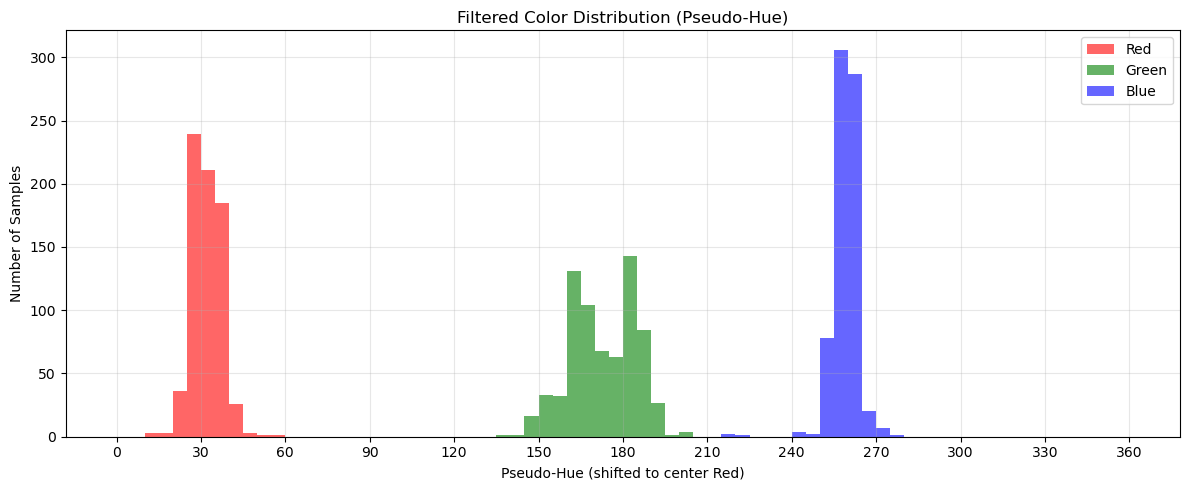

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Reference RGB values (for computing distance and pseudo-hue)
TRUE_COLORS = {
    'Red': (255, 0, 0),
    'Green': (0, 255, 0),
    'Blue': (0, 0, 255)
}

def pseudo_hue(r, g, b):
    """
    Convert an RGB triplet to an approximate perceptual hue.
    The hue is shifted so that red is centered.
    """
    r_norm, g_norm, b_norm = r / 255, g / 255, b / 255
    angle = np.arctan2(np.sqrt(3) * (g_norm - b_norm), 2 * r_norm - g_norm - b_norm)
    deg = np.degrees(angle) % 360
    return (deg + 30) % 360  # shift to center red

def filter_dataframe_zscore(df, threshold=2.5):
    """
    Filters the DataFrame using a z-score based method.
    For each color channel column, compute the mean and standard deviation.
    A row is kept only if for all nine channels, the absolute difference from the mean
    is within threshold * standard deviation.
    """
    cols = [f'{color} {ch}' for color in TRUE_COLORS for ch in ['R', 'G', 'B']]
    
    valid_mask = np.ones(len(df), dtype=bool)
    for col in cols:
        mean_val = df[col].mean()
        std_val = df[col].std()
        # if std_val is zero, assume no variation (so skip filtering for that column)
        if std_val == 0:
            continue
        valid_mask &= (np.abs(df[col] - mean_val) <= threshold * std_val)
    
    filtered_df = df[valid_mask].reset_index(drop=True)
    return filtered_df

def compute_summary_and_hues(df, original_count):
    """
    For each color group, compute summary statistics (using the true color as reference)
    and build a list of pseudo-hues from the cleaned DataFrame.
    """
    summary = []
    pseudo_hues = []
    
    for color, true_rgb in TRUE_COLORS.items():
        col_r = df[f'{color} R']
        col_g = df[f'{color} G']
        col_b = df[f'{color} B']
        
        # Compute RGB distances for each sample
        distances = np.array([
            np.sqrt((r - true_rgb[0])**2 + (g - true_rgb[1])**2 + (b - true_rgb[2])**2)
            for r, g, b in zip(col_r, col_g, col_b)
        ])
        
        # Build pseudo-hue list for each valid sample
        for r, g, b in zip(col_r, col_g, col_b):
            hue = pseudo_hue(r, g, b)
            pseudo_hues.append((hue, color))
        
        remaining_samples = len(df)
        removed_samples = original_count - remaining_samples
        
        summary.append({
            'Color': color,
            'Original Total': original_count,
            'Remaining Samples': remaining_samples,
            'Removed Samples': removed_samples,
            'Mean RGB Distance': np.mean(distances) if remaining_samples > 0 else np.nan,
            'Max RGB Distance': np.max(distances) if remaining_samples > 0 else np.nan
        })
    return pd.DataFrame(summary), pseudo_hues

def plot_rgb_hue_distribution(pseudo_hues, save_path=None):
    """
    Plot a histogram of pseudo-hues for each color group.
    """
    bins = np.linspace(0, 360, 73)  # 5-degree bins
    colors_map = {'Red': 'red', 'Green': 'green', 'Blue': 'blue'}
    
    plt.figure(figsize=(12, 5))
    for color in TRUE_COLORS:
        hue_vals = [h for h, col in pseudo_hues if col == color]
        plt.hist(hue_vals, bins=bins, alpha=0.6, label=color, color=colors_map[color])
    
    plt.xlabel("Pseudo-Hue (shifted to center Red)")
    plt.ylabel("Number of Samples")
    plt.title("Filtered Color Distribution (Pseudo-Hue)")
    plt.xticks(np.arange(0, 361, 30))
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        print(f"Plot saved to: {save_path}")
    plt.show()

# Main usage
if __name__ == "__main__":
    csv_path = '/Users/xiaos/Downloads/Suinan_train_data_cleaned.csv'
    
    # Read the original CSV and record the original count
    original_df = pd.read_csv(csv_path)
    original_count = len(original_df)
    
    # Filter the DataFrame using the z-score based filtering method
    cleaned_df = filter_dataframe_zscore(original_df, threshold=2.5)
    
    # Save the cleaned CSV file
    base, ext = os.path.splitext(csv_path)
    cleaned_csv_path = base + "_cleaned_zscore.csv"
    cleaned_df.to_csv(cleaned_csv_path, index=False)
    print(f"Cleaned CSV saved to: {cleaned_csv_path}")
    
    # Compute summary and pseudo-hue values on the cleaned DataFrame
    report_df, pseudo_hues = compute_summary_and_hues(cleaned_df, original_count)
    
    print("Filtered Color Accuracy Report (Row-wise removal if any channel is outlying):")
    print(report_df.to_string(index=False, float_format=lambda x: f"{x:.2f}"))
    
    # Save the plot in the same directory as the CSV file
    plot_save_path = base + "_cleaned_zscore_plot.png"
    plot_rgb_hue_distribution(pseudo_hues, save_path=plot_save_path)


Color Accuracy Report:
Color  Total Samples  Off Samples  Off %  Mean RGB Distance  Max RGB Distance
  Red           3208         3190  99.44                NaN               NaN
Green           3208         3206  99.94                NaN               NaN
 Blue           3208         3187  99.35                NaN               NaN


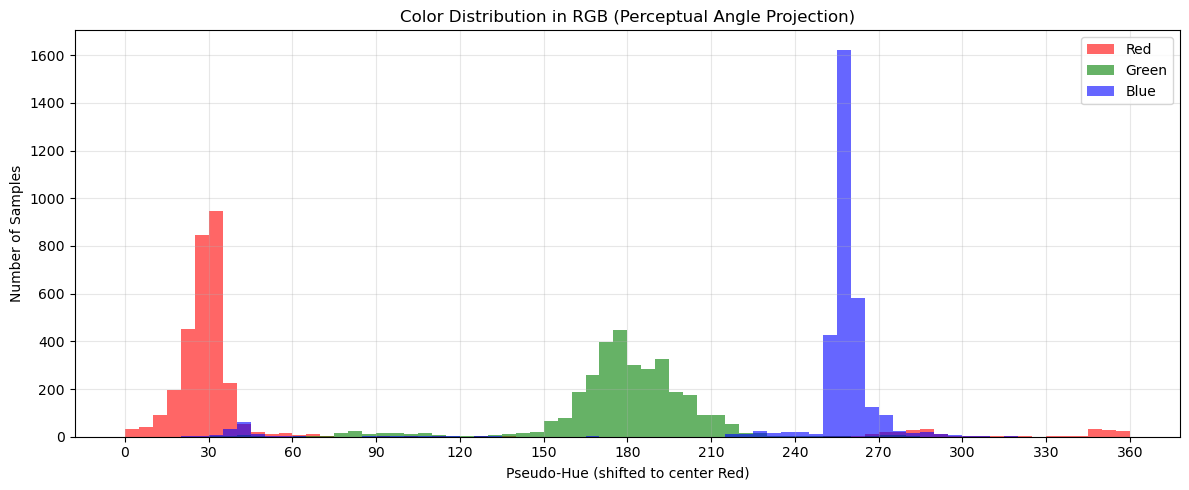

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Reference RGB values
TRUE_COLORS = {
    'Red': (255, 0, 0),
    'Green': (0, 255, 0),
    'Blue': (0, 0, 255)
}

def color_distance(c1, c2):
    """Euclidean distance in RGB space"""
    return np.sqrt(sum((a - b) ** 2 for a, b in zip(c1, c2)))

def pseudo_hue(r, g, b):
    """Approximate perceptual hue using an angle-like projection in RGB space"""
    r_norm, g_norm, b_norm = r / 255, g / 255, b / 255
    angle = np.arctan2(np.sqrt(3) * (g_norm - b_norm), 2 * r_norm - g_norm - b_norm)
    deg = np.degrees(angle) % 360
    return (deg + 30) % 360  # Shift to center red

def analyze_color_accuracy(csv_path, distance_threshold=50):
    df = pd.read_csv(csv_path)
    summary = []
    pseudo_hues = []

    for color_name, true_rgb in TRUE_COLORS.items():
        try:
            r_vals = df[f'{color_name} R']
            g_vals = df[f'{color_name} G']
            b_vals = df[f'{color_name} B']
        except KeyError:
            continue

        total = len(r_vals)
        off_count = 0
        distances = []

        for r, g, b in zip(r_vals, g_vals, b_vals):
            dist = color_distance((r, g, b), true_rgb)
            distances.append(dist)
            hue = pseudo_hue(r, g, b)
            pseudo_hues.append((hue, color_name))
            if dist > distance_threshold:
                off_count += 1

        summary.append({
            'Color': color_name,
            'Total Samples': total,
            'Off Samples': off_count,
            'Off %': (off_count / total) * 100,
            'Mean RGB Distance': np.mean(distances),
            'Max RGB Distance': np.max(distances)
        })

    return pd.DataFrame(summary), pseudo_hues

def plot_rgb_hue_distribution(pseudo_hues):
    bins = np.linspace(0, 360, 73)  # 5-degree bins
    colors = {'Red': 'red', 'Green': 'green', 'Blue': 'blue'}

    plt.figure(figsize=(12, 5))
    for label in TRUE_COLORS:
        hue_vals = [h for h, l in pseudo_hues if l == label]
        plt.hist(hue_vals, bins=bins, alpha=0.6, label=label, color=colors[label])

    plt.xlabel("Pseudo-Hue (shifted to center Red)")
    plt.ylabel("Number of Samples")
    plt.title("Color Distribution in RGB (Perceptual Angle Projection)")
    plt.xticks(np.arange(0, 361, 30))
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Main usage
if __name__ == "__main__":
    csv_path = '/Users/xiaos/Downloads/formatted_data.csv'
    report_df, pseudo_hues = analyze_color_accuracy(csv_path)

    print("Color Accuracy Report:")
    print(report_df.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

    plot_rgb_hue_distribution(pseudo_hues)
